In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=c323f16c16a6735631a2352fa60e61ff48d8c28b3a55f06a646d4947460d76c9
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [5]:
import scanpy as sc

In [49]:
adata = sc.read_h5ad('/content/drive/MyDrive/CS273B/TSP_SS2.h5ad')
gene_names = adata.var.index.tolist()
expression_matrix = adata.X.toarray()

In [50]:
print (len(gene_names))

58482


In [7]:
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
import pandas as pd  # Import pandas library
import matplotlib.pyplot as plt
import seaborn as sns

n_components = 10  # Number of topics/components
model = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
W = model.fit_transform(expression_matrix)  # Assuming gene_expression_matrix is loaded

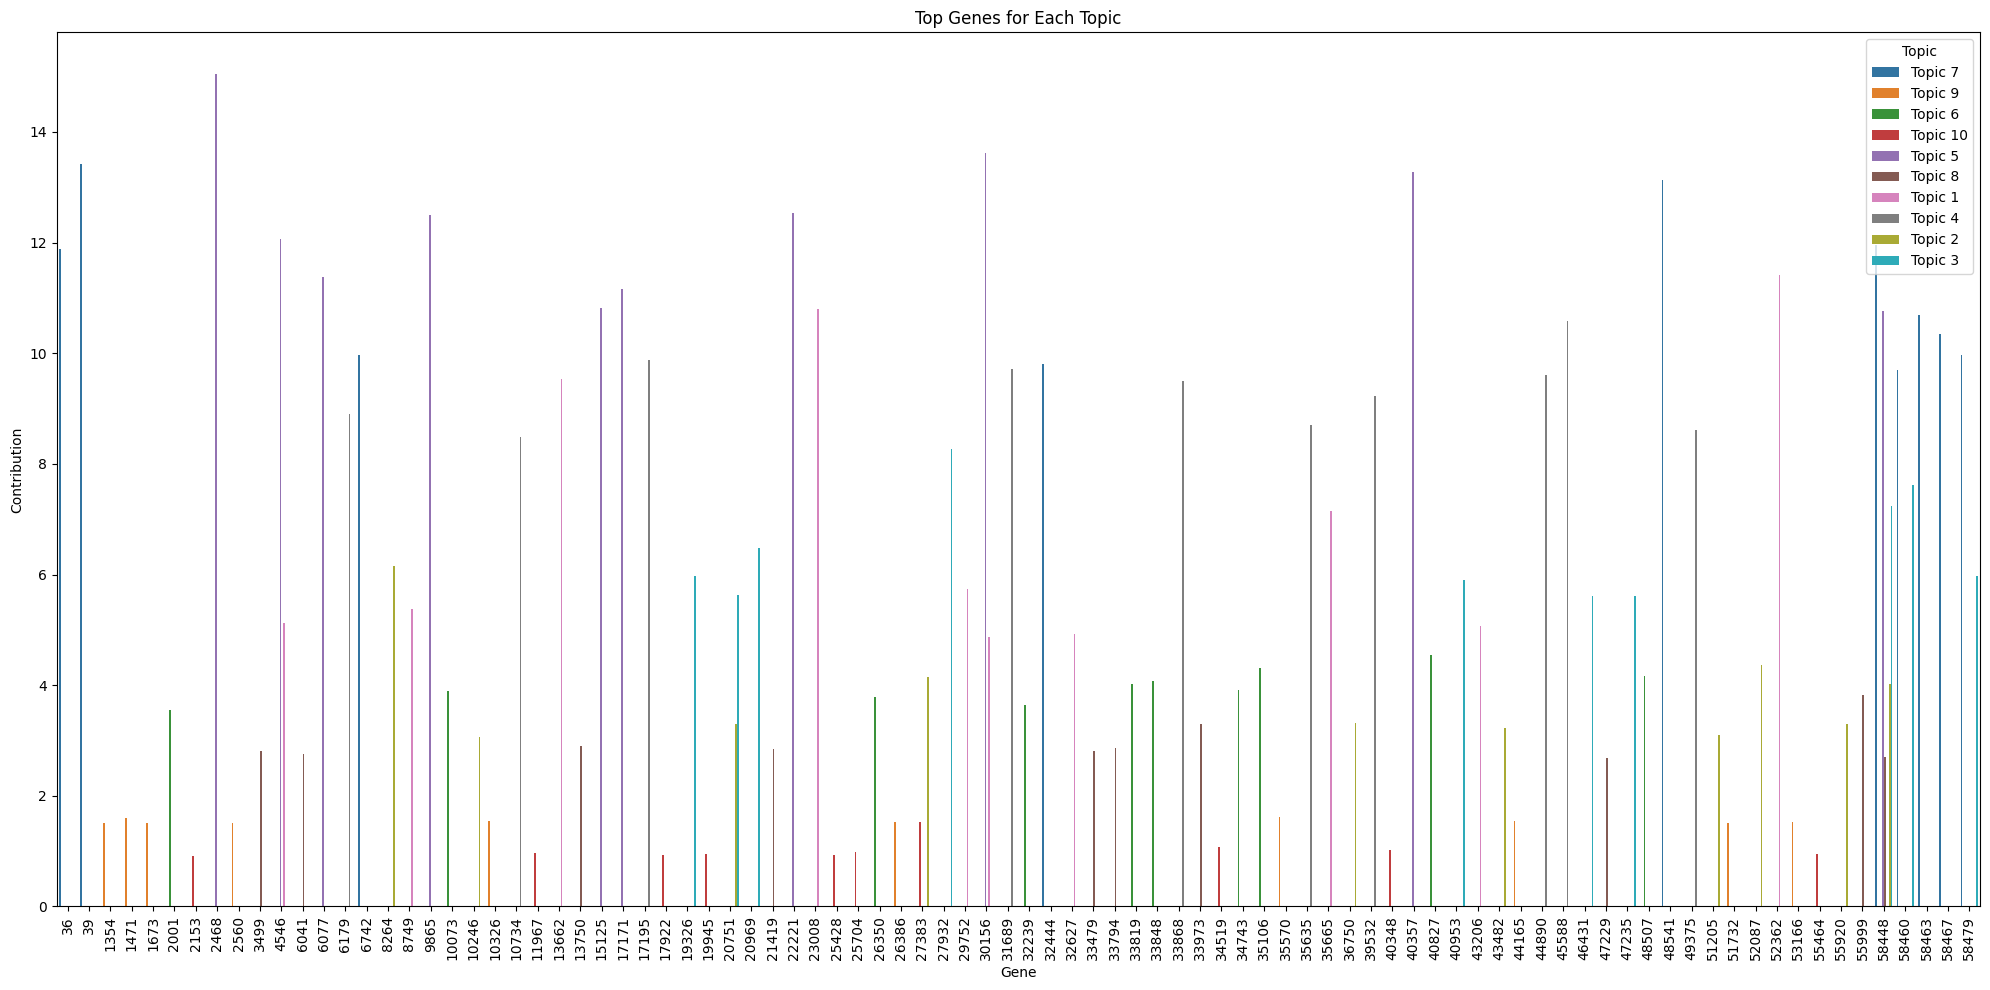

In [8]:

H = model.components_

# Plot the top genes for each topic
top_genes_per_topic = 10  # Number of top genes to display
genes = expression_matrix.columns if isinstance(expression_matrix, pd.DataFrame) else range(expression_matrix.shape[1])

# Prepare data for a single plot
plot_data = []

for topic_idx in range(n_components):
    top_genes_idx = H[topic_idx].argsort()[-top_genes_per_topic:][::-1]
    top_genes = [genes[i] for i in top_genes_idx]
    top_genes_values = H[topic_idx, top_genes_idx]

    for gene, value in zip(top_genes, top_genes_values):
        plot_data.append({
            'Gene': gene,
            'Contribution': value,
            'Topic': f'Topic {topic_idx + 1}'
        })

plot_df = pd.DataFrame(plot_data)

# Plot using Seaborn
plt.figure(figsize=(20, 10))
sns.barplot(data=plot_df, x='Gene', y='Contribution', hue='Topic', dodge=True)
plt.title('Top Genes for Each Topic')
plt.xticks(rotation=90)  # Rotate gene names for better readability
plt.tight_layout()
plt.show()

In [9]:
b_matrix = pd.DataFrame(H.T, index=genes)
b_matrix.columns = [f'Topic {i+1}' for i in range(n_components)]

# Display the b_matrix
print(b_matrix)

        Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7  \
0      0.000000  0.031912  0.000000  0.000000  0.058157  0.076623  0.044586   
1      0.193098  1.042244  0.454214  0.101015  0.144715  0.000000  1.003789   
2      0.026223  0.014591  0.012141  0.030198  0.000000  0.018256  0.034015   
3      0.001442  0.012231  0.004130  0.000000  0.001143  0.003160  0.023596   
4      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
58477  0.934415  1.424684  1.933752  2.121649  3.308847  0.066626  7.112176   
58478  0.046725  0.111901  0.000000  0.000000  0.880969  0.000000  1.368035   
58479  2.043132  0.719512  5.978648  5.879583  6.695062  1.255668  9.966837   
58480  0.000019  0.000000  0.000000  0.000220  0.000000  0.000000  0.007433   
58481  3.091344  0.277169  0.795986  0.000000  0.890107  0.000000  6.198588   

        Topic 8   Topic 9  Topic 10  
0      0.0000

In [133]:
# now I need to extract our topics and top genes
def get_top_genes(beta_matrix, feature_names, top_n=10):
  top_genes = []
  for topic_idx in range(n_components):
    top_genes_idx = H[topic_idx].argsort()[-top_genes_per_topic:][::-1]
    top_genes_values = [feature_names[i] for i in top_genes_idx]
    top_genes.append(top_genes_values)
  return top_genes

In [55]:
import requests
from multiprocessing import Pool

def get_gene_names(ensembl_ids):
    server = "https://rest.ensembl.org"
    ext = "/lookup/id"
    headers = {"Content-Type": "application/json", "Accept": "application/json"}

    all_gene_names = {}
    for i in range(0, len(ensembl_ids), 1000):
        batch_ids = ensembl_ids[i: i + 1000]
        data = {"ids": batch_ids}
        response = requests.post(server + ext, headers=headers, json=data)

        if not response.ok:
            response.raise_for_status()

        decoded = response.json()
        gene_names = {ensembl_id: decoded[ensembl_id].get('display_name') if decoded[ensembl_id] is not None else None
                      for ensembl_id in batch_ids}
        all_gene_names.update(gene_names)

    return all_gene_names

In [134]:
top_genes = get_top_genes(H, feature_names)

In [155]:
final_top_genes = []
for top_gene in top_genes:
  feature_names_list = get_gene_names(top_gene)
  final_top_genes.append([val for key, val in feature_names_list.items()])

In [156]:
all_features = get_gene_names(gene_names)

In [141]:
final_top_genes = [[x for x in inner_list if x is not None] for inner_list in final_top_genes]

In [142]:
print (final_top_genes[3])

['MFAP4', 'GPX3', 'SERPING1', 'SERPINF1', 'C1S', 'FBLN5', 'EFEMP1', 'DCN', 'C3', 'ABI3BP']


In [68]:
import numpy as np
import pandas as pd
import itertools

# Function to build the co-occurrence network using a matrix for efficiency
def build_cooccurrence_network_fast(gene_sets):
    # Flatten the list of gene sets and create a unique list of genes
    all_genes = sorted(set(itertools.chain.from_iterable(gene_sets)))
    gene_index = {gene: idx for idx, gene in enumerate(all_genes)}

    # Initialize a co-occurrence matrix
    cooccurrence_matrix = np.zeros((len(all_genes), len(all_genes)), dtype=int)

    for gene_set in gene_sets:
        if len(gene_set) > 1:
            indices = [gene_index[gene] for gene in gene_set]
            for i, j in itertools.combinations(indices, 2):
                cooccurrence_matrix[i, j] += 1
                cooccurrence_matrix[j, i] += 1

    # Convert the matrix to a DataFrame for easier handling
    cooccurrence_df = pd.DataFrame(cooccurrence_matrix, index=all_genes, columns=all_genes)
    return cooccurrence_df

In [69]:
# Import data from MsigDB

import os
import requests
url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/7.5.1/c5.all.v7.5.1.symbols.gmt"

response = requests.get(url)
gmt_content = response.text

# Save the file
gmt_file_path = "h.all.v7.5.1.symbols.gmt"
with open(gmt_file_path, "w") as gmt_file:
    gmt_file.write(gmt_content)

# Function to parse the .gmt file
def parse_gmt(file_path):
    gene_sets = []
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split("\t")
            gene_set_name = parts[0]
            genes = parts[2:]
            gene_sets.append(genes)
    return gene_sets

# Parse the downloaded .gmt file
gene_sets = parse_gmt(gmt_file_path)

In [70]:
cooccurrence_network = build_cooccurrence_network_fast(gene_sets)

In [160]:
from itertools import combinations
def calculate_gsea_coherence(top_genes, cooccurrence_network):
    coherence_scores = []
    for topic in top_genes:
        score = 0
        pairs_count = 0
        for gene1, gene2 in combinations(topic, 2):
            if gene1 in cooccurrence_network.keys() and gene2 in cooccurrence_network[gene1]:
                score += 1
            pairs_count += 1
        coherence_scores.append(score / pairs_count if pairs_count > 0 else 0)
    return np.mean(coherence_scores)

# Calculate coherence score based on MsigDB gene sets
gsea_coherence_score = calculate_gsea_coherence(final_top_genes, cooccurrence_network)
print("GSEA Coherence Score:", gsea_coherence_score)

GSEA Coherence Score: 0.3844444444444444


In [166]:
import torch
X_reconstructed = np.dot(W, H)

# Function to calculate the log-likelihood
def log_likelihood(X, X_reconstructed):
    likelihood = X * np.log(X_reconstructed + 1e-10) - X_reconstructed
    return np.sum(likelihood)

# Calculate the log-likelihood
ll = log_likelihood(expression_matrix, X_reconstructed)

# Number of words
n_words = torch.Tensor(adata.raw.X.todense()).sum().item()

# Calculate perplexity
perplexity = np.exp(-ll / n_words)
print(f"Perplexity: {perplexity}")

Perplexity: 1.012172695407166


In [149]:
feature_names_list = [val for key, val in feature_names_list.items()]

In [ ]:
import h5py
import numpy as np

file_path = 'TSP_SS2.h5ad'

with h5py.File(file_path, 'r') as file:
    if 'var' in file and '_index' in file['var']:
        gene_names = np.array(file['var']['_index']).astype(str)  # Convert bytes to str if necessary
        print("Gene names loaded successfully:", gene_names[:10])  # Print the first 10 gene names to verify
    else:
        print("Unable to locate gene names in 'var' group.")
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
import gseapy as gp
import pandas as pd  # Import pandas library
import matplotlib.pyplot as plt
import seaborn as sns


n_components = 10  # Number of topics/components
model = NMF(n_components=n_components, init='random', random_state=0, max_iter=500)
W = model.fit_transform(gene_expression_matrix)  # Assuming gene_expression_matrix is loaded


# --- 3. Gene Ontology Enrichment ---

n_top_genes = 20  # Adjust if needed

top_gene_indices = np.argsort(W, axis=0)[-n_top_genes:]
go_analysis_results = {}  # Use a dictionary to store results with topic labels

for i in range(n_components):
    topic_genes = gene_names[top_gene_indices[:, i]]  # Extract genes for this topic
    enr = gp.enrichr(
        gene_list=topic_genes.tolist(),
        gene_sets='GO_Biological_Process_2021',
        outdir=None,
        no_plot=True,
    )

    # Store the results with a descriptive key (topic number)
    go_analysis_results[f"Topic {i + 1}"] = pd.DataFrame(enr.results)

# --- 4. Results Processing and Visualization ---

# Combine results from the dictionary into a single DataFrame
all_results = pd.concat(go_analysis_results, names=['Topic'])

# Example: get top enriched term for each topic
top_terms = all_results.groupby('Topic').apply(lambda x: x.nlargest(1, 'Adjusted P-value'))

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=top_terms, x='Topic', y='-log10(Adjusted P-value)', hue='Term')
plt.xticks(rotation=45)
plt.show()

Gene names loaded successfully: ['ENSG00000223972' 'ENSG00000227232' 'ENSG00000278267' 'ENSG00000243485'
 'ENSG00000284332' 'ENSG00000237613' 'ENSG00000268020' 'ENSG00000240361'
 'ENSG00000186092' 'ENSG00000238009']
